# **Network Science Project:** "Sexism in Colours"

# **README**

This project is aimed to collect data from Twitter, based on the topic ***Sexism in Colors***, with some hashtags related with the gender bias in colors. 

Developers: 

Umut Berk Cakmakci

Meltem Yanoglu

Alara Selen Ozgen

Beliz Gunay

## Set up

1. Tokens and keys should not be kept in colab notebooks.

2. In order to efficiently save your data it's best to connect the notebook with your Google Drive. 

3. Libraries that we need (for now) are *requests*, to handle our API requests, and *pandas* to easily view and store the results.

4. Colab environment offers you loads of pre-installed python libraries (you can check which ones by executing `!pip freeze`); *however* if your library is not on the list, you need to manually install it.

In [ ]:
import os
os.environ['TOKEN'] = "" #add your Twitter API token here!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [ ]:
import requests 
import pandas as pd 
import time
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator
import datetime
import dateutil.parser
from datetime import datetime as dt
from datetime import timedelta
import tweepy
import networkx as nx

In [ ]:
!mkdir /content/drive/MyDrive/[TwitterData]/

mkdir: cannot create directory ‘/content/drive/MyDrive/[TwitterData]/’: File exists


In [ ]:
path = "/content/drive/MyDrive/[TwitterData]/"
error_log_path = "/content/drive/MyDrive/[TwitterData]/"

# **SECTION A:** Collecting Data from Twitter

## Step 1: authenticate

In order to authenticate our request, we need to create a request header and add an authorization field. You can authorize a request by using the bearer token, or the API consumer/secret keys. Here we do it with bearer token for the sake of simplicity.


### Set up headers

In [ ]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

headers = create_headers(os.environ['TOKEN'])

## Step 2: build a search query


**Ingredients**: endpoint, parameters and operators

For endpoint we use: https://api.twitter.com/2/tweets/search/all

If you don't have Twitter academic research account, you can't search more than last 7 days. If you want to go way back, you need to have academic research account. 

**Example parameters**: 

* query: the text of your search (required) - max 512 chars
* end_time: the newest date for your tweets
* start_time: the oldest date for your tweets
(format for date: YYYY-MM-DDTHH:mm:ssZ (ISO 8601/RFC 3339))
* max_results: between 10 (default) and 100
* tweet_fields: which fields to get (if empty, you only get id&text&edit 
history)
* user_fields, place_fields, expansions
* next_token: to get the next page of results 


**Example operators**: keyword (menstruation), exact phrase("sexual education"), hashtag ("#metoo"), emoji (😬), logical operators (AND = a blank space), OR, NOT), from: or to: (tweets from a user or directed to a user), @ (tweets that mention the user, @NASA), is:retweet, is: reply , is:quote, lang: ("en")

Grouping is done with brackets. F.e (#prolife abortion) OR (#prochoice abortion)

See more here: 

Operators: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

Parameters: https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-recent

In [ ]:
def create_url(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint):
    
    search_url = endpoint #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    #also can request different fields, e.g ids of users ... 
    query_params = {'query': query, 'end_time': end_time, 'start_time': start_time,
                    'max_results': max_results, 'expansions': expansions, 'tweet.fields': tweet_fields, 
                    'user.fields': user_fields, 'place.fields': place_fields}

    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    #only change the default value of next_token if it is a real value returned in the response
    if next_token is not None and next_token != '':
      params['next_token'] = next_token
    #create a "GET" request to the specified url, add headers and parameters
    response = requests.request("GET", url, headers = headers, params = params)
    if response.status_code != 200:
        #if something goes wrong, we need to know
        raise Exception(response.status_code, response.text)
    #otherwise, we want the payload of our response, which contains our tweet(s)

    return response.json()

def get_data(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint, next_token=""):
  results = []
  while next_token is not None:
    try:    
      url = create_url(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint)
      json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
      #if we have results, they will be in the field 'data' of our response
      if "data" in json_response:
        results.extend(json_response["data"])
        print(str(len(json_response["data"])) + " Tweets downloaded in this batch.")
      #the next_token is added to the field 'meta' of our response
      if "meta" in json_response:
        if "next_token" in json_response["meta"].keys():
          next_token = json_response["meta"]["next_token"]          
        else:
          next_token = None
      else:
        next_token = None
      #to control the rate limit we need to slow down our download
      time.sleep(3)

    except Exception as e:
      print("Error occured", e)
      print("Next token value", next_token)
      error_log = {"Error":e, "Next token":next_token, "Day":start_time, 
                   "Downloaded":len(results)}
      pd.DataFrame.from_dict(error_log, orient="index").to_csv(error_log_path+query+"_"+start_time+"_"+next_token+".csv")
      return(results, next_token)

  print("Done")
  
  return (results, next_token)

To anticipate the amount of data we'll need to download we can use the counts endpoint (https://developer.twitter.com/en/docs/twitter-api/tweets/counts/api-reference/get-tweets-counts-all).

*ONLY AVAILABLE WITH ACADEMIC RESEARCH ACCESS*

In [ ]:
def create_url_counts(keyword, start_date, end_date, endpoint):
  search_url = endpoint
  query_params = {'query': keyword, 'start_time': start_date, 'end_time': end_date}
  return (search_url, query_params)

def connect_to_endpoint_counts(url, headers, params, next_token = None):
    #print(next_token)
    if next_token is not None and next_token != '':
      params['next_token'] = next_token
    response = requests.request("GET", url, headers = headers, params = params)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def get_data_counts(keyword, start_time, end_time, next_token, endpoint):
  results = 0
  result_count = {}
  
  while next_token is not None:
    try:     
      url = create_url_counts(keyword, start_time, end_time, endpoint)
      json_response = connect_to_endpoint_counts(url[0], headers, url[1], next_token) 
      if "data" in json_response:
        for date in json_response["data"]:
          result_count[date["start"]] = date["tweet_count"]      
      if "meta" in json_response:
        if "next_token" in json_response["meta"].keys():
          next_token = json_response["meta"]["next_token"]
        else:
          next_token = None
        if "total_tweet_count" in json_response["meta"].keys():
          results += int(json_response["meta"]["total_tweet_count"])
      else:
        next_token = None
    except Exception as e:
      print("Error occured", e)
  #print("Done")

  return (results, next_token, result_count)

In [ ]:
start_time = "2020-12-01T00:00:00.000Z"
end_time = "2022-12-02T00:00:00.000Z"
query_text = "#genderbias #color"
endpoint = ""
path = ""
max_results = 100
no_days = 15

In [ ]:
results, _, count = get_data_counts(query_text, start_time, end_time, "", "https://api.twitter.com/2/tweets/counts/all")

In [ ]:
count_df = pd.DataFrame.from_dict(count, orient="index").reset_index().rename(columns={"index": "date", 0: "count"})
count_df2=count_df.sort_values(by=("date")).reset_index().drop(columns="index")
count_df3=count_df2.set_index("date", inplace=True)

ax = count_df2.plot()
ax.tick_params(axis="x", labelrotation= 90)
plt.tight_layout()
plt.show()

## Step 3: download and save the data

We call the function, filling in the desired parameters. We convert the data into a pandas dataframe to easily manipulate it (view, edit, save). We save the data in the PICKLE format, so we can recover the exact data types later.

In [ ]:
start_time = "2010-12-01T13:00:00.000Z"
end_time = "2023-02-17T13:00:00.000Z"
query_text = "(#colorbias OR #colourbias OR #genderbias OR #sexism OR #sexismincolors OR #sexismincolours OR pinkforgirls OR blueforboys OR #genderstereotype OR #colorpreferences OR #coloremotions OR #colourpreferences OR #colouremotions) (#red OR #orange OR #yellow OR #green OR #purple OR #grey OR #brown OR #white OR pink OR blue)"
# OR #bianco OR #rosa OR #blu OR #arancia OR #verde OR #rosso OR #giallo OR #brown OR #marrone)
# OR (genere colore sessismo)"


#query_text = "kızlar erkekler pembe mavi" OR (kızlar erkekler pembe mavi)  OR #kızlariçinpembe OR #erkekleriçinmavi OR #kizlaricinpembe OR #erkeklericinmavi
#color OR #colour OR #valencebias
endpoint = "https://api.twitter.com/2/tweets/search/all/"
path = "/content/drive/MyDrive/[TwitterData]/"
max_results = 100
no_days = 15

Simple search and at the same time, download all the tweets found. 

In [ ]:
tweets = get_data(query_text, start_time = start_time, end_time = end_time, 
          max_results=max_results, expansions='author_id,in_reply_to_user_id,geo.place_id', 
          tweet_fields='id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source,entities',
          user_fields='id,name,username,created_at,description,public_metrics,verified',
          place_fields='full_name,id,country,country_code,geo,name,place_type',
          endpoint=endpoint)[0]          
tweets_df = pd.DataFrame(tweets)
tweets_df.to_pickle(path+"mixed5_tweets.pkl")

98 Tweets downloaded in this batch.
98 Tweets downloaded in this batch.
99 Tweets downloaded in this batch.
99 Tweets downloaded in this batch.
100 Tweets downloaded in this batch.
93 Tweets downloaded in this batch.
93 Tweets downloaded in this batch.
94 Tweets downloaded in this batch.
99 Tweets downloaded in this batch.
94 Tweets downloaded in this batch.
95 Tweets downloaded in this batch.
98 Tweets downloaded in this batch.
77 Tweets downloaded in this batch.
96 Tweets downloaded in this batch.
97 Tweets downloaded in this batch.
98 Tweets downloaded in this batch.
94 Tweets downloaded in this batch.
97 Tweets downloaded in this batch.
96 Tweets downloaded in this batch.
98 Tweets downloaded in this batch.
95 Tweets downloaded in this batch.
100 Tweets downloaded in this batch.
97 Tweets downloaded in this batch.
95 Tweets downloaded in this batch.
49 Tweets downloaded in this batch.
91 Tweets downloaded in this batch.
100 Tweets downloaded in this batch.
98 Tweets downloaded in t

Displaying the tweets you downloaded in Pandas dataframe format.

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
tweets_df = pd.DataFrame(tweets)
display(tweets_df)

,in_reply_to_user_id,text,public_metrics,id,entities,author_id,edit_history_tweet_ids,reply_settings,referenced_tweets,lang,conversation_id,created_at,geo
0,1449090760226361355,@SendDopaminePls @lozz990 @honestsportz @jk_ro...,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1625924147950899200,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",2307002678,[1625924147950899200],everyone,"[{'type': 'replied_to', 'id': '162586404914460...",en,1625465418222542849,2023-02-15T18:24:59.000Z,NaN
1,NaN,Thanks @raam9420 for breaking the stereotypes...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1623223805589213185,"{'mentions': [{'start': 7, 'end': 16, 'usernam...",18864545,[1623223805589213185],everyone,"[{'type': 'quoted', 'id': '1622596510952341511'}]",en,1623223805589213185,2023-02-08T07:34:47.000Z,NaN
2,NaN,RT @ClaudiadeCast13: Have you ever heard of “#...,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",1621800018922590208,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",3036241429,[1621800018922590208],everyone,"[{'type': 'retweeted', 'id': '1621437432615821...",en,1621800018922590208,2023-02-04T09:17:10.000Z,NaN
3,NaN,Have you ever heard of “#pinktax”?🤔\n \nIt mea...,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",1621437432615821315,"{'mentions': [{'start': 227, 'end': 232, 'user...",3074707636,[1621437432615821315],everyone,NaN,en,1621437432615821315,2023-02-03T09:16:23.000Z,NaN
4,NaN,RT @JamesRisdon007: Hollywood has gone so #wok...,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",1619845793741172738,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",1512590494441742337,[1619845793741172738],everyone,"[{'type': 'retweeted', 'id': '1619058399337156...",en,1619845793741172738,2023-01-29T23:51:47.000Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,NaN,"Target ""boy"" aisles are blue. ""Girl"" aisles a...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",18068516540256257,"{'hashtags': [{'start': 56, 'end': 63, 'tag': ...",214699433,[18068516540256257],everyone,NaN,en,18068516540256257,2010-12-23T22:20:44.000Z,NaN
3022,75919117,@listen2LuLu lol u knw i got tha blue and whit...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",14367079016693760,"{'hashtags': [{'start': 63, 'end': 73, 'tag': ...",54998925,[14367079016693760],everyone,"[{'type': 'replied_to', 'id': '143660931371581...",en,14366093137158144,2010-12-13T17:12:33.000Z,NaN
3023,NaN,"RT @smalltownqueer: The Toys ""R"" Us website al...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",12685215994486785,"{'annotations': [{'start': 24, 'end': 27, 'pro...",166421185,[12685215994486785],everyone,NaN,en,12685215994486785,2010-12-09T01:49:25.000Z,NaN
3024,NaN,.@JoshWeichhand Yep. They had a separate YakBa...,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",11971980366450688,"{'annotations': [{'start': 41, 'end': 47, 'pro...",68773980,[11971980366450688],everyone,NaN,en,11971980366450688,2010-12-07T02:35:17.000Z,NaN


In [ ]:
lang=tweets_df.groupby(["lang"]).count().sort_values(by="id", ascending=False)
lang

,in_reply_to_user_id,text,public_metrics,id,entities,author_id,edit_history_tweet_ids,reply_settings,referenced_tweets,conversation_id,created_at,geo
lang,,,,,,,,,,,,
en,399,2850,2850,2850,2849,2850,2850,2850,1435,2850,2850,65
und,2,88,88,88,88,88,88,88,51,88,88,2
qme,5,27,27,27,27,27,27,27,7,27,27,0
de,2,13,13,13,13,13,13,13,8,13,13,1
es,0,10,10,10,10,10,10,10,2,10,10,0
fr,1,8,8,8,8,8,8,8,3,8,8,1
qht,1,7,7,7,7,7,7,7,6,7,7,0
it,0,6,6,6,6,6,6,6,4,6,6,0
da,0,4,4,4,4,4,4,4,1,4,4,0


Displaying the tweets you downloaded in text format.

In [ ]:
for idx, row in tweets_df.iterrows():
  print(row["geo"],row["id"],row["text"])

# **SECTION B:** Working with Twitter Data

### Step 1:  Loading the data

If you want to load the results you have previously saved, simply execute the next code, specifying the path to the file.

You will need to either upload it to the Colab workspace or copy the path to the file on Drive.

In [ ]:
tweets_df = pd.read_pickle(path+"mixed29_tweets.pkl")
tweets_df.columns
tweets_df

,entities,reply_settings,text,author_id,public_metrics,conversation_id,id,lang,created_at,edit_history_tweet_ids,referenced_tweets,in_reply_to_user_id,geo
0,"{'urls': [{'start': 141, 'end': 164, 'url': 'h...",everyone,#nipples #wearenipples #colors #photography #p...,1332852166181195779,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1332854589184421889,1332854589184421889,qme,2020-11-29T01:11:11.000Z,[1332854589184421889],NaN,NaN,NaN
1,"{'urls': [{'start': 264, 'end': 287, 'url': 'h...",everyone,Good article here. But can Irish radio change ...,2598198187,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",1331228906540720128,1331228906540720128,en,2020-11-24T13:31:19.000Z,[1331228906540720128],NaN,NaN,NaN
2,"{'annotations': [{'start': 27, 'end': 37, 'pro...",everyone,go watch the last video of sam collins on yout...,2850233285,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1330898307238027266,1330898307238027266,en,2020-11-23T15:37:37.000Z,[1330898307238027266],NaN,NaN,NaN
3,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",everyone,@Austin_Maguire so true bring back menly men w...,911662506447396865,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1330342607319347203,1330344933627219970,en,2020-11-22T02:58:43.000Z,[1330344933627219970],"[{'type': 'replied_to', 'id': '133034260731934...",419604793,NaN
4,"{'urls': [{'start': 68, 'end': 91, 'url': 'htt...",everyone,@moby_dickhead God will bring menly men back! ...,1196715288609329152,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1328447487900835841,1329889304299048964,en,2020-11-20T20:48:12.000Z,[1329889304299048964],"[{'type': 'replied_to', 'id': '132844748790083...",163436555,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,"{'hashtags': [{'start': 13, 'end': 19, 'tag': ...",everyone,I wonder why #white #women can wear short clot...,248501477,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",110898615341428737,110898615341428737,en,2011-09-06T02:14:24.000Z,[110898615341428737],NaN,NaN,NaN
457,"{'hashtags': [{'start': 24, 'end': 29, 'tag': ...",everyone,Babes only drink pretty #beer... http://ping.f...,83173921,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",96913732650807296,96913732650807296,en,2011-07-29T12:03:29.000Z,[96913732650807296],NaN,NaN,NaN
458,"{'hashtags': [{'start': 45, 'end': 52, 'tag': ...",everyone,@3BLMedia Hey! What about men? I am ready ;) #...,77254498,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",32587677928783872,32587907663396864,en,2011-02-01T23:55:37.000Z,[32587907663396864],"[{'type': 'replied_to', 'id': '325876779287838...",23484042,NaN
459,"{'hashtags': [{'start': 108, 'end': 115, 'tag'...",everyone,RT @ecosalon: Founder's response to Sara's cri...,63256850,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",29322445278158849,29322445278158849,en,2011-01-23T23:39:50.000Z,[29322445278158849],"[{'type': 'retweeted', 'id': '2923793035874304...",NaN,NaN


### Step 2: Preprocessing the data

In our dataframe we have the entire Tweet object. Some columns that might be of particular interest to us are: 

*   created_at - date when Tweet was posted
*   id - unique Tweet identifier
*   text - the content of the Tweet
*   author_id - unique Tweet identifier
*   retweeted_status  - information about the original Tweet
*   public metrics - quote/reply/retweet/favorite count
*   entities - hashtags, urls, annotations present in Tweet

We can filter the dataframe and keep only columns we are interested in. You can pick which columns you'd like to keep and put them int the column_list below.



In [ ]:
tweets_filtered = tweets_df.copy() #it's a good idea to work on the copy of original dataframe, so we can always go back to it if we mess something up
column_list = ["id","author_id","created_at", "text","entities","public_metrics", "lang", "geo"]
tweets_filtered = tweets_filtered[column_list]

In [ ]:
tweets_filtered

,id,author_id,created_at,text,entities,public_metrics,lang,geo
0,1332854589184421889,1332852166181195779,2020-11-29T01:11:11.000Z,#nipples #wearenipples #colors #photography #p...,"{'urls': [{'start': 141, 'end': 164, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",qme,NaN
1,1331228906540720128,2598198187,2020-11-24T13:31:19.000Z,Good article here. But can Irish radio change ...,"{'urls': [{'start': 264, 'end': 287, 'url': 'h...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",en,NaN
2,1330898307238027266,2850233285,2020-11-23T15:37:37.000Z,go watch the last video of sam collins on yout...,"{'annotations': [{'start': 27, 'end': 37, 'pro...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN
3,1330344933627219970,911662506447396865,2020-11-22T02:58:43.000Z,@Austin_Maguire so true bring back menly men w...,"{'mentions': [{'start': 0, 'end': 15, 'usernam...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN
4,1329889304299048964,1196715288609329152,2020-11-20T20:48:12.000Z,@moby_dickhead God will bring menly men back! ...,"{'urls': [{'start': 68, 'end': 91, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",en,NaN
...,...,...,...,...,...,...,...,...
456,110898615341428737,248501477,2011-09-06T02:14:24.000Z,I wonder why #white #women can wear short clot...,"{'hashtags': [{'start': 13, 'end': 19, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN
457,96913732650807296,83173921,2011-07-29T12:03:29.000Z,Babes only drink pretty #beer... http://ping.f...,"{'hashtags': [{'start': 24, 'end': 29, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN
458,32587907663396864,77254498,2011-02-01T23:55:37.000Z,@3BLMedia Hey! What about men? I am ready ;) #...,"{'hashtags': [{'start': 45, 'end': 52, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN
459,29322445278158849,63256850,2011-01-23T23:39:50.000Z,RT @ecosalon: Founder's response to Sara's cri...,"{'hashtags': [{'start': 108, 'end': 115, 'tag'...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",en,NaN


### Step 3: Extracting words/hashtags

There are many ways to build networks from the data we download from Twitter.

One possibility is to have a bipartite network of Tweets and words/hashtags and then observe word, hashtag or word-hashtag projections.

#### Extracting words

In order to extract words, we first need to clean the Tweet text. This way we will remove punctuation, hashtags/mentions/urls (they are preserved in the entity column anyway). We will also turn all letters to lowercase.

You can also consider removing stopwords, removing words that are not in the english language corpora, lematizing the words, etc. I suggest you research nltk library and its possibilities.

In [ ]:
import re
import string
# NLTK tools
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
#stop_words = nltk.corpus.stopwords.words("english")
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
              "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
              'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 
              'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
              'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
              'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
              'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
              'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
              'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
              't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
              "weren't", 'won', "won't", 'wouldn', "wouldn't", 'to', 'in', 'almost', "that's", 'go', 'la', 'w', 
              'ca', 'u', 'ne', 'n', 'via', 'really', 'time', 'recent', 'de', 'literally', 'window', 'need', 'newly', 
              'like',	'pretty', 'overshoot', 'violence', 'expression',	'claim', 'banana', 'left', 'say', 'el', 'se', 
              'know', 'tell', 'night', 'fast', 'shade', 'told', 'caption', 'try', 'act', 'say', 'mano', 'suit', 'post']


def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub("[0-9]+", "",tweet) # remove numbers
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = re.sub("\\\\n", " ", tweet)
    tweet = " ".join(tweet.split())
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in words and not w.lower() in stop_words)
     #remove stop words
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize
    tweet = str.lower(tweet) #to lowercase
    return tweet

tweets_filtered["clean_text"] = tweets_filtered["text"].map(cleaner)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
tweets_filtered

,id,author_id,created_at,text,entities,public_metrics,lang,geo,clean_text
0,1332854589184421889,1332852166181195779,2020-11-29T01:11:11.000Z,#nipples #wearenipples #colors #photography #p...,"{'urls': [{'start': 141, 'end': 164, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",qme,NaN,
1,1331228906540720128,2598198187,2020-11-24T13:31:19.000Z,Good article here. But can Irish radio change ...,"{'urls': [{'start': 264, 'end': 287, 'url': 'h...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",en,NaN,good article radio change put jersey buy gende...
2,1330898307238027266,2850233285,2020-11-23T15:37:37.000Z,go watch the last video of sam collins on yout...,"{'annotations': [{'start': 27, 'end': 37, 'pro...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN,watch last video sam collins bring back men love
3,1330344933627219970,911662506447396865,2020-11-22T02:58:43.000Z,@Austin_Maguire so true bring back menly men w...,"{'mentions': [{'start': 0, 'end': 15, 'usernam...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN,true bring back men
4,1329889304299048964,1196715288609329152,2020-11-20T20:48:12.000Z,@moby_dickhead God will bring menly men back! ...,"{'urls': [{'start': 68, 'end': 91, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",en,NaN,god bring men back praise amen
...,...,...,...,...,...,...,...,...,...
456,110898615341428737,248501477,2011-09-06T02:14:24.000Z,I wonder why #white #women can wear short clot...,"{'hashtags': [{'start': 13, 'end': 19, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN,wonder wear short clothes bad
457,96913732650807296,83173921,2011-07-29T12:03:29.000Z,Babes only drink pretty #beer... http://ping.f...,"{'hashtags': [{'start': 24, 'end': 29, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN,drink
458,32587907663396864,77254498,2011-02-01T23:55:37.000Z,@3BLMedia Hey! What about men? I am ready ;) #...,"{'hashtags': [{'start': 45, 'end': 52, 'tag': ...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,NaN,hey men ready
459,29322445278158849,63256850,2011-01-23T23:39:50.000Z,RT @ecosalon: Founder's response to Sara's cri...,"{'hashtags': [{'start': 108, 'end': 115, 'tag'...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",en,NaN,founder response critical piece renewable


We are going to loop through the dataframe and then through the words in the clean text. We are going to add the words as keys to dictionary and use their frequencies as values.

In [ ]:
tweets_filtered.loc[tweets_filtered["clean_text"].isnull(),"clean_text"] = ""

tweet_tokenizer = nltk.TweetTokenizer()
#initialize an empty dict
unique_words = {}

for idx, row in tweets_filtered.iterrows():
  if row["clean_text"] != "":
    for word in tweet_tokenizer.tokenize(row["clean_text"]):
      unique_words.setdefault(word,0)
      unique_words[word] += 1

unique_words

{'good': 12,
 'article': 5,
 'radio': 1,
 'change': 8,
 'put': 1,
 'jersey': 1,
 'buy': 2,
 'gender': 9,
 'balance': 1,
 'female': 3,
 'top': 2,
 'last': 2,
 'made': 1,
 'breakthrough': 1,
 'watch': 2,
 'video': 1,
 'sam': 1,
 'collins': 1,
 'bring': 16,
 'back': 18,
 'men': 66,
 'love': 10,
 'true': 3,
 'god': 2,
 'praise': 2,
 'amen': 1,
 'need': 2,
 'end': 9,
 'also': 5,
 'people': 14,
 'girl': 6,
 'harry': 1,
 'con': 2,
 'para': 2,
 'maya': 2,
 'still': 10,
 'follow': 1,
 'slut': 1,
 'b': 7,
 'talk': 7,
 'trump': 7,
 'person': 1,
 'post': 1,
 'tweet': 1,
 'h': 2,
 'vogue': 1,
 'hope': 2,
 'lose': 3,
 'respect': 5,
 'admit': 1,
 'certain': 1,
 'initial': 1,
 'excitement': 1,
 'micro': 1,
 'second': 2,
 'place': 5,
 'astute': 1,
 'team': 1,
 'instead': 2,
 'get': 16,
 'woke': 1,
 'inherent': 2,
 'laziness': 1,
 'human': 2,
 'search': 1,
 'would': 7,
 'first': 5,
 'one': 17,
 'take': 4,
 'photo': 4,
 'hatred': 2,
 'call': 3,
 'times': 1,
 'black': 7,
 'forget': 1,
 'sexual': 3,
 'assa

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df = uw_df.reset_index().drop(columns=["index"])

We can inspect the words as a dataframe. 


You can always save this dataframe as .csv for future reference.

In [ ]:
uw_df.head(50)

,Word,Count
0,men,66
1,pink,31
2,woman,24
3,see,18
4,back,18
5,one,17
6,get,16
7,bring,16
8,white,16
9,day,15


In [ ]:
df11 = uw_df[0:30]
df11

,Word,Count
0,men,66
1,pink,31
2,woman,24
3,see,18
4,back,18
5,one,17
6,get,16
7,bring,16
8,white,16
9,day,15


In [ ]:
df112 = df11.drop([4,5,6,7,9,10,14,15,16,18,19,21,])
df111=df112[0:10]

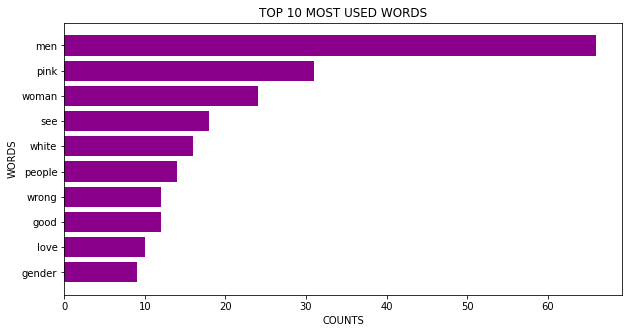

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df111 = df111.sort_values(by=['Count'])

plt.figure(figsize=(10,5))
# Create horizontal bars
plt.barh(y=df111['Word'], width=df111['Count'], color='darkmagenta');
#plt.barh(y_pos, height, color='mediumorchid')
 
plt.title("TOP 10 MOST USED WORDS")
plt.ylabel("WORDS")
plt.xlabel("COUNTS")
# Show graphic
plt.show()

In [ ]:
uw_df.to_csv(path+"mixed5_words.csv")

#### Extracting the hashtags

We are going to loop through the dataframe and then through the hashtags in the entities. We are going to add the hashtags as keys to dictionary and use their frequencies as values. At the same time, we are going to save them in a list and add them to a separate column to facilitate our future work.

In [ ]:
tweets_filtered.loc[tweets_df["entities"].isnull(), "entities"] = None
tweets_filtered["hashtags"] = ""

unique_hashtags = {}
index = 0

for idx, row in tweets_filtered.iterrows():
  if row["entities"] is not None and "hashtags" in row["entities"]:
    hl = []
    for hashtag in row["entities"]["hashtags"]:
      tag = hashtag["tag"].lower()
      unique_hashtags.setdefault(tag, 0)
      unique_hashtags[tag] += 1
      hl.append(tag)
 
    tweets_filtered.at[idx,"hashtags"] = hl

unique_hashtags = dict(sorted(unique_hashtags.items(), key=lambda item: item[1], reverse=True))
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)

In [ ]:
df12 = uh_df[0:50]
df12

,Hashtag,Count
0,sexism,349
1,white,191
2,racism,155
3,pink,145
4,women,41
5,feminism,34
6,trump,33
7,blue,31
8,orange,31
9,pinkforgirls,31


In [ ]:
df122 = df12[0:10]
df122

,Hashtag,Count
0,sexism,349
1,white,191
2,racism,155
3,pink,145
4,women,41
5,feminism,34
6,trump,33
7,blue,31
8,orange,31
9,pinkforgirls,31


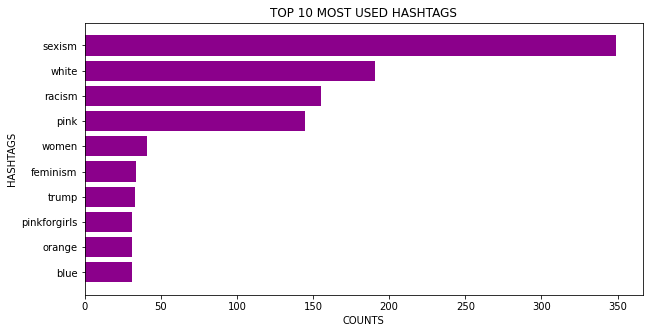

In [ ]:
df122 = df122.sort_values(by=['Count'])

plt.figure(figsize=(10,5))
# Create horizontal bars
arr = [8, 9, 12, 12, 12, 17, 17, 18, 21, 31]
plt.barh(y=df122['Hashtag'], width=df122['Count'], color='darkmagenta');
#plt.barh(y_pos, height, color='mediumorchid')
 
# Create names on the x-axis
#plt.yticks(y_pos, bars)


plt.title("TOP 10 MOST USED HASHTAGS")
plt.ylabel("HASHTAGS")
plt.xlabel("COUNTS")
# Show graphic
plt.show()

In [ ]:
uh_df.to_csv(path+"mixed5_hashtags.csv")

### Step 4: Building the network

We are going to use the networkx library, which is a Python library that enables network science analysis of the data.

We are going to use it to create our network and extract edgelist from it, since we can easily import it to Gephi (a software we are going to see in visualization labs).

However, it offers implemented algorithms for analysis (for example PageRank) that you can use out-of-box to analyze your network.

But first, we will loop through our dataframe and connect words and hashtags if they appear together in the same Tweet.

In [ ]:
import itertools
import networkx as nx

In [ ]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

network = {}
network_key = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] + [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network):
            network.setdefault(pair,0)
            network[pair] += 1 
    
network_df = pd.DataFrame.from_dict(network, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df.head(50)

,pair,weight
282,"(sexism, white)",186
664,"(racism, sexism)",159
669,"(racism, white)",137
832,"(sexism, pink)",102
1616,"(white, men)",51
1631,"(men, sexism)",43
2615,"(sexism, woman)",40
712,"(sexism, women)",38
2095,"(white, trump)",38
2831,"(pink, pinkforgirls)",38


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G.nodes()))
print(len(G.edges()))

2005
24402


In [ ]:
nx.write_graphml(G,path+"mixed5_network.pkl")

In [ ]:
r = nx.degree_pearson_correlation_coefficient(G)
print(r)

-0.12456820188379748


In [ ]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import random
import warnings

In [ ]:
G

In [ ]:
# calculating the assortativity coefficients wrt different proeprties
cr = nx.attribute_assortativity_coefficient(G, "cluster")
r_in_out = nx.degree_assortativity_coefficient(G, x="in", y="out")
nr = nx.numeric_assortativity_coefficient(G, "edges")

# drawing the network
nx.draw_networkx_nodes(G)
nx.draw_networkx_labels(G)
nx.draw_networkx_edges(G, edge_color="0.7")

KeyError: ignored

### Save edgelist

In [ ]:
filename = path+"/mixed33_edgelist.csv"
nx.write_weighted_edgelist(G, filename, delimiter=",")

In [ ]:
#add header with appropriate column names (works on collab and Linux/Mac(?))
!sed -i.bak 1i"Source,Target,Weight" /content/drive/MyDrive/[TwitterData]/mixed33_edgelist.csv

#### Create and save node list


In [ ]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

word_nodes

,Id,Label
0,go,go
1,impossible,impossible
2,find,find
3,major,major
4,problem,problem
...,...,...
1200,founder,founder
1201,critical,critical
1202,renewable,renewable
1203,impact,impact


In [ ]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])
hashtag_nodes

,Id,Label
0,sexism,sexism
1,white,white
2,racism,racism
3,pink,pink
4,feminism,feminism
...,...,...
1606,advertizing,advertizing
1607,inventor,inventor
1608,now,now
1609,toronto,toronto


In [ ]:
nodelist = hashtag_nodes.append(word_nodes, ignore_index=True)

nodelist.to_csv(path+"mixed33_nodelist.csv",index=False)

# **SECTION C:** Visualization with igraph

### Install the libraries

In [ ]:
!pip install python-igraph
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9076 sha256=6c30d4afae0e244da9ba81a7a2dc63820f2db0fac5f36c3afd3e705ecb7abfa3
  Stored in directory: /root/.cache/pip/wheels/04/eb/68/b70fc5f1163b5a3e9e6aaaea5fb57a8ff4c0c4988505a4fe0f
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cairocffi: filename=cairocffi-1.4.0-py3-none-any.whl size=88775 sha256=51ff22cb6215cd92c64741a0cb4e9a2d9a2acd7d4234b1cc521f18cf81d31ee7
  Stored in directory: /root/.cache/pip/wheels/01/a9/c0/5c05f9dd73c21f9a7716690642823cdba55594d17a9bd

### Import libraries

In [ ]:
import pandas as pd
import itertools
import networkx as nx
import igraph as ig
import ast
import cairocffi as cairo
import random
import math
import os

In [ ]:
path = "/content/drive/MyDrive/[TwitterData]/"
error_log_path = "/content/drive/MyDrive/[TwitterData]/"

## Step 1: Create graph from data

### 1. Create networkx graph from weighted edgelist

In [ ]:
!cat /content/drive/MyDrive/[TwitterData]/_edgelist.csv

In [ ]:
with open("/content/drive/MyDrive/[TwitterData]/mixed33_edgelist.csv",'r') as f:
    with open(path+"edgelist4.csv",'w') as f1:
        next(f) # skip header line
        index = 0
        limit = 300
        for line in f:
            f1.write(line)
            index += 1
            if index == limit:
                break
friendship_nw = nx.read_weighted_edgelist(path+"edgelist4.csv",delimiter=",")

### 2. Change into igraph

In [ ]:
g = ig.Graph.from_networkx(friendship_nw)
for vertice in g.vs:
    print(vertice.attributes())
for edge in g.es:
    print(edge.attributes())

{'_nx_name': 'woke'}
{'_nx_name': 'straight'}
{'_nx_name': 'white'}
{'_nx_name': 'man'}
{'_nx_name': 'go'}
{'_nx_name': 'impossible'}
{'_nx_name': 'find'}
{'_nx_name': 'major'}
{'_nx_name': 'addiction'}
{'_nx_name': 'drugs'}
{'_nx_name': 'alcohol'}
{'_nx_name': 'violence'}
{'_nx_name': 'racism'}
{'_nx_name': 'sexism'}
{'_nx_name': 'transphobia'}
{'_nx_name': 'homophobia'}
{'_nx_name': 'tv'}
{'_nx_name': 'problem'}
{'_nx_name': 'extreme'}
{'_nx_name': 'free'}
{'_nx_name': 'show'}
{'_nx_name': 'mgtow'}
{'_nx_name': 'mra'}
{'_nx_name': 'misandry'}
{'_nx_name': 'mens'}
{'_nx_name': 'rights'}
{'_nx_name': 'red'}
{'_nx_name': 'pill'}
{'_nx_name': 'dating'}
{'_nx_name': 'marriage'}
{'_nx_name': 'herbivore'}
{'_nx_name': 'divorce'}
{'_nx_name': 'separated'}
{'_nx_name': 'army'}
{'_nx_name': 'breakup'}
{'_nx_name': 'family'}
{'_nx_name': 'court'}
{'_nx_name': 'sexist'}
{'_nx_name': 'friends'}
{'_nx_name': 'benefits'}
{'_nx_name': 'child'}
{'_nx_name': 'support'}
{'_nx_name': 'military'}
{'_nx_n

## Step 2: Plotting the graph

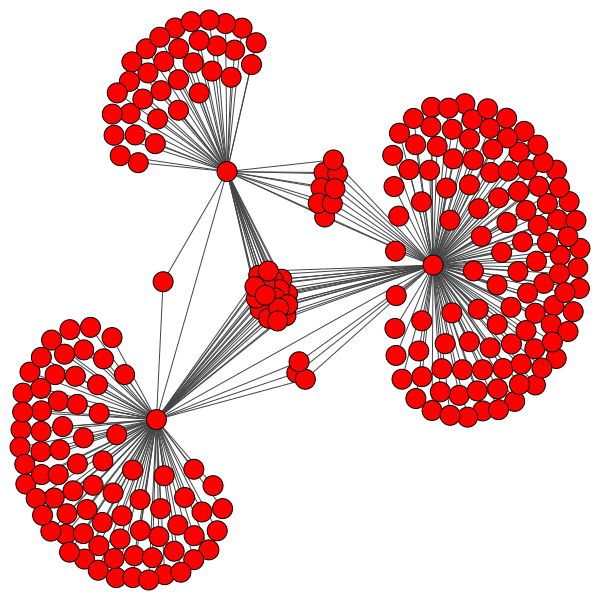

In [ ]:
ig.plot(g)

### Setting plot properties

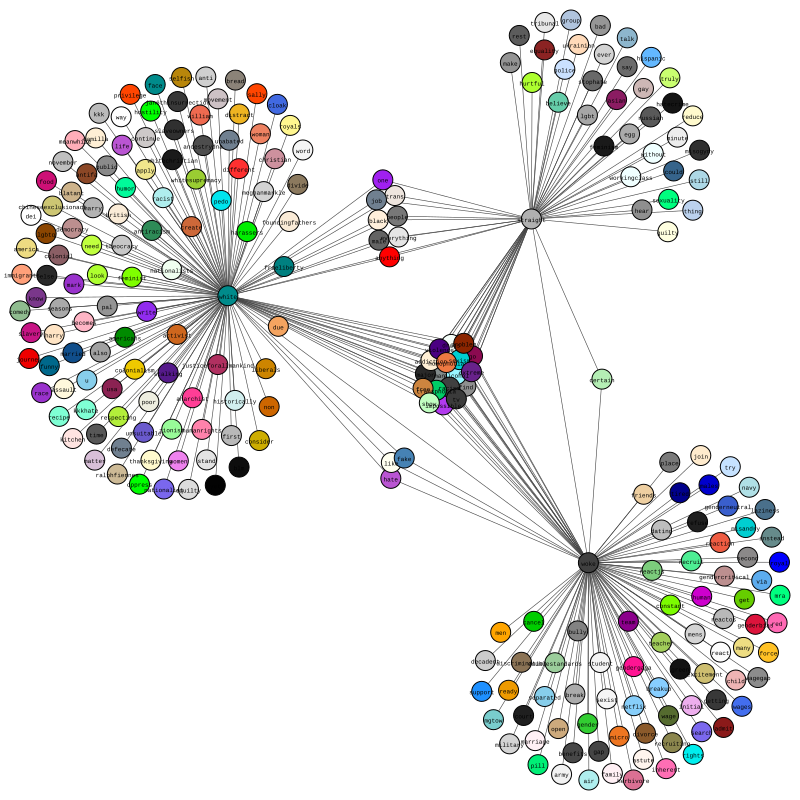

In [ ]:
#dict of X11 color names 
colors = ig.drawing.colors.known_colors
colors = list(colors.keys())
#set label to be names of nx graph nodes
g.vs["label"] = g.vs["_nx_name"]

visual_style = {}
#node size
visual_style["vertex_size"] = 20
#node color
visual_style["vertex_color"] =  random.sample(colors,len(g.vs()))
#node label
visual_style["vertex_label"] = g.vs["label"]
#node label color
visual_style["vertex_label_color"] = "black"
#node label size
visual_style["vertex_label_size"] = 6
#visual_style["vertex_label_size"] = [1*degree for degree in g.degree()]
#edge thickness
visual_style["edge_width"] = 0.6
#visual_style["edge_width"] = [0.14 * int(weight) for weight in g.es["weight"]]
#bounding box
visual_style["bbox"] = (800, 800)
#margin
visual_style["margin"] = 20

ig.plot(g, "friendship_network.png", **visual_style)

### Choosing a layout

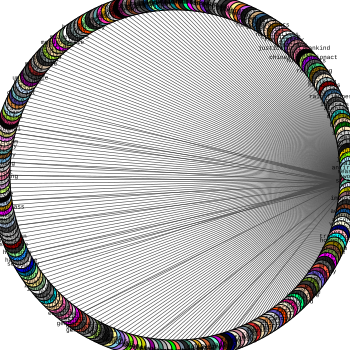

In [ ]:
#use layout algorithms
#The default is auto, which selects a layout algorithm automatically based on the size and connectedness of
#the graph. For this graph it's one of the "force" algorithms (fr, kk - they all give similar values)

colsep, rowsep = 300, 300
width, height = 350, 350

visual_style = {}
#node size
visual_style["vertex_size"] = 20
#node color
visual_style["vertex_color"] = [random.choice(colors) for v in g.vs()]
#node label
visual_style["vertex_label"] = g.vs["label"]
#node label color
visual_style["vertex_label_color"] = "black"
#node label size
visual_style["vertex_label_size"] = 6
#edge thickness
visual_style["edge_width"] = 0.6

plot = ig.plot("plot.png", bbox=(350, 350), background="white")


#plot.add(g, **visual_style,bbox=(colsep/2 + width*0, rowsep/2 + height*0, -colsep/2 + width*(0+1), -rowsep/2 + height*(0+1)),layout="fr")
#plot.add(g, **visual_style,bbox=(colsep/2 + width*1, rowsep/2 + height*0, -colsep/2 + width*(1+1), -rowsep/2 + height*(0+1)),layout="kk")
#plot.add(g, **visual_style,bbox=(colsep/2 + width*0, rowsep/2 + height*1, -colsep/2 + width*(0+1), -rowsep/2 + height*(1+1)),layout="circle")
plot.add(g, **visual_style,layout="circle")

plot

## Step 3: Saving the plot

### As PDF, PNG or SVG

In [ ]:
visual_style

{'vertex_size': 20,
 'vertex_color': ['blue1',
  'aquamarine2',
  'salmon3',
  'sienna',
  'webgray',
  'grey81',
  'light yellow',
  'grey12',
  'grey62',
  'goldenrod3',
  'mediumpurple4',
  'mistyrose',
  'peachpuff',
  'grey40',
  'dark magenta',
  'grey68',
  'pink4',
  'plum1',
  'navy blue',
  'mediumpurple1',
  'paleturquoise1',
  'darkslategray3',
  'powderblue',
  'hotpink4',
  'grey24',
  'dark olive green',
  'dim gray',
  'teal',
  'grey96',
  'lightsalmon4',
  'grey66',
  'honeydew1',
  'navajowhite1',
  'dodger blue',
  'firebrick3',
  'gray4',
  'seagreen1',
  'gray1',
  'gray63',
  'gray4',
  'gray50',
  'green',
  'magenta3',
  'ivory',
  'gray54',
  'wheat',
  'salmon3',
  'darkred',
  'gray48',
  'honeydew4',
  'sienna4',
  'medium slate blue',
  'darkgreen',
  'lightcyan1',
  'slateblue2',
  'violet red',
  'seashell1',
  'gray0',
  'light slate gray',
  'paleturquoise2',
  'darkolivegreen2',
  'gray2',
  'grey14',
  'maroon1',
  'oldlace',
  'royalblue4',
  'gray4

In [ ]:
ig.plot(g, "friendship_network.png", **visual_style)

### Alternative 

In [ ]:
visual_style = {}
#node size
visual_style["vertex_size"] = 20
#node color
visual_style["colors"] = ["pink" for node in g.vs()]
#node label
visual_style["labels"] = g.vs["label"]
#node label size
visual_style["font_size"] = "14"
#edge thickness
visual_style["edge_stroke_widths"] = [0.14 * int(weight) for weight in g.es["weight"]]
#bounding box
visual_style["width"] = 500
visual_style["height"] = 500

g.write_svg("friendship_network",**visual_style)

# **SECTION D:** Some Network Properties Visualization Examples

We are gonna use a ready-to-use newtork to see some functionalities of the network. 

### 1. Create networkx graph with node and edge information

You need to use *edges_numericalid.csv* and *nodes.csv* files to built the network.

In [ ]:
edges = pd.read_csv(path+'edges_numericalid.csv', sep=";")
friendship_nw_prop = nx.from_pandas_edgelist(edges, 'Source', 'Target', ['Weight'])

nodes = pd.read_csv(path+'nodes.csv', header=0,delim_whitespace=True)
nodes = nodes.set_index('Id').to_dict('index').items()

friendship_nw_prop.add_nodes_from(nodes)
print(friendship_nw_prop.nodes(data=True))
print(friendship_nw_prop.edges(data=True))


### 2. Change into igraph

In [ ]:
g_prop = ig.Graph.from_networkx(friendship_nw_prop)

for vertice in g_prop.vs:
    print(vertice.attributes())
for edge in g_prop.es:
    print(edge.attributes())

### 3. Color nodes according to properties

In [ ]:
colors_dict = {"Bosnia and Herzegovina":"blue", "Italy":"darkgreen","Germany":"yellow","Austria":"red","The Netherlands":"White"}

visual_style = {}
#node size
visual_style["vertex_size"] = 20
#node color
visual_style["vertex_color"] = [colors_dict[country] for country in g_prop.vs["Country"] ]
#node label
visual_style["vertex_label"] = g_prop.vs["Label"]
#label size
visual_style["vertex_label_size"] = [3*degree if degree>2 else 7 for degree in g_prop.degree()]
#edge thickness
visual_style["edge_width"] = [0.1 * int(weight) for weight in g_prop.es["Weight"]]
#bounding box
visual_style["bbox"] = (500, 500)
#margin
visual_style["margin"] = 20
ig.plot(g_prop, **visual_style)


### 4. Look at network properties

#### Size

In [ ]:
# GRAPH ORDER = NO OF NODES

nodes = g_prop.vs()
edges = g_prop.es()

print("Graph order:", len(nodes))

# GRAPH SIZE = NO OF EDGES

print("Graph size:", len(edges))

# DENSITY - HOW CONNECTED ARE THE NODES? NO OF EDGES/NO OF POSSIBLE EDGES

print("Number of possible edges (N*(N-1)):", 22*21)
print("Graph density:", g_prop.density())


ig.plot(g_prop, **visual_style)

#### Connectedness

In [ ]:
# CONNECTEDNESS - EASIEST TO INSPECT VISUALLY 

print("Is the graph connected:","yes" if g_prop.is_connected() else "no")

#IF NOT YOU CAN FIND ISOLATED COMPONENENTS
for component in g_prop.components():
  print(component)

#### Node degrees

In [ ]:
# CONNECTIVITY - HOW WELL CONNECTED A NODE IS

print("Node degrees:"),

for node in g_prop.vs():
    print("  ",node["Label"],"degree:",node.degree())

#SET SIZE PROP TO DEGREE
visual_style["vertex_size"] = [4*degree if degree>3 else 20 for degree in g_prop.degree()]

#COLOR NEAREST NEIGHBORS OF A CERTAIN NODE
node_name = "Lejla"
for node in nodes:
    if node["Label"] == node_name:
        node_index = node.index
    
neighbors = g_prop.neighborhood(nodes[node_index],order=1)
visual_style["vertex_color"] = ["fuchsia" if node.index in neighbors else "grey" for node in nodes]
visual_style["edge_color"] = "darkgrey"

ig.plot(g_prop, **visual_style)


#### Network diameter

In [ ]:
# DIAMETER - HOW FAR ARE THE TWO MOST DISTANT NODES

print("Network diameter:", g_prop.diameter(directed=False))

# GET NODES IN THE DIAMETER PATH 
diameter_path = []
d = g_prop.get_diameter()
for i in range(0, g_prop.diameter()):
  diameter_path.append((d[i], d[i+1]))
# GET EDGES IN THE DIAMETER PATH
diameter_edges = g_prop.get_eids(pairs=diameter_path, directed=False)


#COLOR THE DIAMETER PATH
visual_style["vertex_color"] = ["red" if node.index in diameter_path else "white" for node in nodes]
visual_style["edge_color"] = ["red" if edge.index in diameter_edges else "black" for edge in edges]


print("Path between most distant nodes:", [nodes[index]["Label"] for index in diameter_path])

# AVERAGE PATH LENGTH - HOW CLOSE ARE THE NODES TO EACH OTHER ON AVERAGE

print("Average path length:", g_prop.average_path_length(directed=False))

ig.plot(g_prop, **visual_style)


#### Shortest paths

In [ ]:
# SHORTEST PATHS 
shortest_paths = {}
for node in nodes:
    shortest_paths[node["Label"]]=[nodes[v]["Label"] for v in g_prop.get_all_shortest_paths(node)
                                                    ]
# SHOW DISTANCES OF SHORTEST PATHS BETWEEN ONE NODE AND EVERYBODY ELSE

node_name = "Lejla"
print("Shortest paths between", node_name,"and other nodes", shortest_paths[node_name])

distances = [len(path) for path in shortest_paths[node_name]]

visual_style["vertex_color"] = ["pink" if node["Label"]==node_name else "grey" for node in nodes]
visual_style["edge_color"] = "darkgrey"

visual_style["vertex_label"] = distances

ig.plot(g_prop, **visual_style)

#### Clustering coefficient

In [ ]:
# GLOBAL OR LOCAL CLUSTERING COEFFICIENT - GENERAL INDICATION OF THE GRAPH'S TENDENCY TO BE ORGANISED INTO CLUSTERS

# GLOBAL CC - NUMBER OF CLOSED TRIPLETS/NUMBER OF POSSIBLE TRIPLETS

print("Global clustering coefficient", g_prop.transitivity_undirected())

# LOCAL CC - ARE THE NEIGHBOURS OF THE NODES ALSO CONNECTED?

print("Local clustering components:")
local_ccs = g_prop.transitivity_local_undirected()
sum_cc = 0
for local_cc in local_ccs:
    if not math.isnan(local_cc):
        sum_cc += local_cc

for node in nodes:
        print("   Local clustering coefficient of node", node["Label"],":",local_ccs[node.index])

        
# AVERAGE CC

print("Average clustering coefficient", sum_cc/len(g_prop.vs()))


#### Communities

In [ ]:
# CLUSTERS, COMMUNITIES, GROUPS - WHAT ARE THE NODES THAT ARE MORE CONNECTED TO EACH OTHER THAN TO OTHER NODES
# check out the different community algorithms and pick the one you'd like

communities = g_prop.community_optimal_modularity()
community_colors = random.sample(colors,len(communities))
node_colors = {}
counter = 0

print("Communities in the network:")

for community in communities:
    print("  ",[nodes[member]["Label"] for member in community])
    for member in community:
        node_colors[member] = community_colors[counter]
   
    counter += 1

visual_style["vertex_color"] = [node_colors[node.index] for node in nodes]
visual_style["vertex_label"] = g.vs["label"]

ig.plot(g_prop, **visual_style)

#### Cliques

In [ ]:
# CLIQUES - TOTALLY CONNECTED SUBCOMPONENTS OF GRAPH

#print("Cliques in graph")
#for clique in g_prop.cliques():
#    print("   ",[nodes[node]["Label"] for node in clique])
    
print("Maximal cliques in graph")
maximal_cliques = g_prop.maximal_cliques()
for clique in maximal_cliques:
    print("   ",[nodes[node]["Label"] for node in clique])

largest_clique = g_prop.largest_cliques()

print("Largest clique",[nodes[node]["Label"] for node in largest_clique])

visual_style["vertex_color"] = ["pink" if node.index in largest_clique[0] else "grey" for node in nodes]


ig.plot(g_prop, **visual_style)


#### Centralities

In [ ]:
# BETWEENESS - BEING A BRIDGE BETWEEN NODES; BETWEENNES CENTRALITY: NUMBER OF SHORTEST PATHS THROUGH A NODE


print("Betweenness centrality:"),
betweenness = g_prop.betweenness(directed=False) 
for bc in betweenness:
    print("   Betweeness centrality of", nodes[betweenness.index(bc)]["Label"],":",bc)

    
# CLOSENESS - BEING IN THE MIDDLE OF A NETWORK

print("Closeness centrality:"),
closeness = g_prop.closeness() 
for node in nodes:
        print("   Closeness centrality of", node["Label"],":",closeness[node.index])


# PRESTIGE(EIGENVECTOR CENTRALITY) - BEING CLOSE TO WELL CONNECTED NODES

eigenvector_centralities = g_prop.eigenvector_centrality() 
print("Eigenvector centrality:"),
eigenvector_centralities = g_prop.eigenvector_centrality() 
for node in nodes:
    print("   Eigenvector centrality of", node["Label"],":",eigenvector_centralities[node.index])

visual_style["vertex_label"] = g_prop.vs["Label"]
visual_style["vertex_size"] = [50*ec for ec in eigenvector_centralities]
visual_style["vertex_color"] = ["maroon" if bc>0.0 else "white" for bc in betweenness]
visual_style["edge_color"] = "grey"


ig.plot(g_prop, **visual_style)


In [ ]:
G = nx.read_gpickle(path+"network.pkl")